# Predicción de fuga de clientes

En este notebook construiremos un modelo para predecir la fuga de clientes de una empresa de telecomunicaciones. Este problema se aborda usando un approach de aprendizaje supervisado y se entrena una modelo de clasificación.

Usaremos las siguientes librerias

- pandas
- scikit-learn
- H20

Leer las instrucciones disponibles en el archivo setup/README.md acerca de como instalar las librerias y habilitar el entorno virtual

La libreria de H2O requiere tener instalado java Runtime Environemnt (jre)

Características de H2O

- Puede realizar preprocesamiento de datos. Conversión categórica y continua.
- Se oucpa de la imputación de los valores ausentes.
- La selección de modelos es una buena tabla de clasificación para los modelos.
- Proporciona un código listo para la implementación.
- Da en formato múltiple. MOJO, POJO y binario. Se recomienda MOJO
- Admite GPU para XGBoost
- Funciona tanto en CPU como GPU

In [50]:
import os, sys, glob
import numpy as np
import pandas as pd
import datetime
import time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

sns.set()
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [51]:
dataDir = 'data'
resultsDir = 'results'
modelsDir = 'models'

In [52]:
if not os.path.exists(resultsDir):
    os.mkdir(resultsDir)

if not os.path.exists(modelsDir):
    os.mkdir(modelsDir)

## Iniciamos servidor de h2o

In [53]:
import h2o

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 59 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 27 days
H2O_cluster_name:,H2O_from_python_rmunoz_pvslcw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,13.44 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


## Cargar datos en H2O

In [54]:
dataFile = os.path.join(dataDir, 'Industria telco Kaggle - analisis de fuga.csv')

dataDF = h2o.import_file(dataFile)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [55]:
type(dataDF)

h2o.frame.H2OFrame

In [56]:
dataDF.head()

customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes
9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.1,1949.4,No
6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.8,3046.05,Yes
6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [57]:
dataDF.types

{'customerID': 'string',
 'gender': 'enum',
 'SeniorCitizen': 'int',
 'Partner': 'enum',
 'Dependents': 'enum',
 'tenure': 'int',
 'PhoneService': 'enum',
 'MultipleLines': 'enum',
 'InternetService': 'enum',
 'OnlineSecurity': 'enum',
 'OnlineBackup': 'enum',
 'DeviceProtection': 'enum',
 'TechSupport': 'enum',
 'StreamingTV': 'enum',
 'StreamingMovies': 'enum',
 'Contract': 'enum',
 'PaperlessBilling': 'enum',
 'PaymentMethod': 'enum',
 'MonthlyCharges': 'real',
 'TotalCharges': 'real',
 'Churn': 'enum'}

## Preparación de datos

### Separacion entre train y test dataset

In [58]:
trainDF, valDF, testDF = dataDF.split_frame(ratios=[0.7, 0.15])

In [59]:
print(len(trainDF))
print(len(valDF))
print(len(testDF))

4910
1035
1098


In [60]:
columnsY = "Churn"

columnsX = dataDF.columns
columnsX.remove("customerID")
columnsX.remove("Churn")

print(columnsX)
print(columnsY)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
Churn


---
## Entrenamiento del modelo de clasificación usando H2O

In [61]:
from h2o.automl import H2OAutoML

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

Parámetros relevantes del método de clasificación de Auto-sklearn

- max_runtime_secs = Limite de tiempo en segundos para buscar modelo óptimo
- max_runtime_secs_per_model = Límite de tiempo en el entrenamiento de un modelo
- max_models = Número máximo de modelos no ensamblados que serán construidos

- include algos = Métodos de clasificación que serán explorados
- exclude algos = Métodos de clasificación que serán excluidos
- nfolds = Usará nfolds para hacer cross-validation
- balance_classes = Determina si se balancearán o no las clases. True o False
- seed = Semilla empleada para los algoritmos que necesitan randomization




Métodos de clasificación disponibles
- Distributed Random Forest (DRF) including both the Random Forest and Extremely Randomized Trees (XRT) models

- Naïve Bayes Classifier

- Gradient Boosting Machine (H2O GBM)

- XGBoost (XGBoost GBM)

- Support Vector Machine (SVM)

- DeepLearning (Fully-connected multi-layer artificial neural network)

- StackedEnsemble

Más info en http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science.html

---
## Modelo 1

Partiremos construyendo un modelo usando solo XGBoost y DRF

In [62]:
model = H2OAutoML(max_runtime_secs=2*60, max_runtime_secs_per_model=30,
                  seed=42, nfolds=0,
                  include_algos=["XGBoost","DRF"], exclude_algos=None, verbosity="info")

In [63]:
model.train(x=columnsX, y=columnsY, training_frame=trainDF, validation_frame=valDF)

AutoML progress: |█
16:06:40.350: Project: AutoML_20201124_160640350
16:06:40.350: Cross-validation disabled by user: no fold column nor nfolds > 1.
16:06:40.350: Setting stopping tolerance adaptively based on the training frame: 0.014271159300492749
16:06:40.350: Build control seed: 42
16:06:40.350: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
16:06:40.363: training frame: Frame key: automl_training_py_184_sid_9a11    cols: 21    rows: 4382  chunks: 64    size: 1005446  checksum: -7470031762962487599
16:06:40.363: validation frame: Frame key: py_185_sid_9a11    cols: 21    rows: 1035  chunks: 64    size: 853740  checksum: -6356839015972839215
16:06:40.363: leaderboard frame: Frame key: automl_leaderboard_py_184_sid_9a11    cols: 21    rows: 528  chunks: 64    size: 840957  checksum: -7214572381716616310
16:06:40.363: blending frame: NULL
16:06:40.363: response co

### Analizamos las métricas de los modelos entrenados

In [64]:
leaderboard = model.leaderboard
leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
DRF_1_AutoML_20201124_160640,0.844729,0.467723,0.594112,0.22436,0.364465,0.132835
XRT_1_AutoML_20201124_160640,0.836825,0.418932,0.579712,0.235779,0.368747,0.135975


### Calculamos las métricas del clasificador

<img src="images/confusion_matrix.jpg"  width="480">

In [16]:
#model.leader.model_performance(testDF)

Resumen del número de clientes no fugados y fugados en el dataset de test

In [65]:
testDF['Churn'].table()

Churn,Count
No,790
Yes,308


In [66]:
predDF = model.leader.predict(testDF)

predDF.head()

drf prediction progress: |████████████████████████████████████████████████| 100%


predict,No,Yes
Yes,0.435303,0.564697
No,0.86,0.14
No,0.849597,0.150403
Yes,0.436242,0.563758
Yes,0.62992,0.37008
Yes,0.626667,0.373333
No,0.788333,0.211667
Yes,0.604667,0.395333
No,0.999665,0.000334728
Yes,0.64973,0.35027


Resumen del numero de la predicción del número de clientes no fugados y fugados

In [67]:
predDF['predict'].table()

predict,Count
No,697
Yes,401


## Matriz de confusion

Usaremos como clase positiva los clientes fugados

In [20]:
testY = testDF.as_data_frame()['Churn'].values
predY = predDF.as_data_frame()['predict'].values

In [21]:
labels = ['Fugado', 'No fugado']
cmDF = pd.DataFrame(confusion_matrix(testY, predY, labels=['Yes', 'No']), index=labels, columns=labels)

cmDF

,Fugado,No fugado
Fugado,174,96
No fugado,148,659


Text(30.5, 0.5, 'Actual')

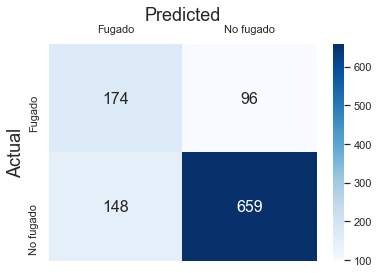

In [22]:
fig, ax = plt.subplots()
sns.heatmap(cmDF, annot=True, annot_kws={"size": 16}, fmt='', cmap=plt.cm.Blues)
plt.tick_params(labelbottom=False, labeltop=True, labelright=False)

ax.set_xlabel('Predicted', fontsize=18)
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Actual', fontsize=18)

In [23]:
print(classification_report(testY, predY, labels=['Yes', 'No']))

              precision    recall  f1-score   support

         Yes       0.54      0.64      0.59       270
          No       0.87      0.82      0.84       807

    accuracy                           0.77      1077
   macro avg       0.71      0.73      0.72      1077
weighted avg       0.79      0.77      0.78      1077



---
## Modelo 2

Probaremos todos los métodos de clasificación, excepto DeepLearning

In [24]:
model = H2OAutoML(max_runtime_secs=5*60, max_runtime_secs_per_model=30,
                  seed=42, nfolds=0,
                  exclude_algos=["DeepLearning"], verbosity="info")

In [25]:
model.train(x=columnsX, y=columnsY, training_frame=trainDF, validation_frame=valDF)

AutoML progress: |
13:57:40.41: Project: AutoML_20201124_135740041
13:57:40.41: Cross-validation disabled by user: no fold column nor nfolds > 1.
13:57:40.41: Setting stopping tolerance adaptively based on the training frame: 0.014154880754301795
13:57:40.41: Build control seed: 42
13:57:40.41: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
13:57:40.81: training frame: Frame key: automl_training_py_3_sid_8351    cols: 21    rows: 4465  chunks: 64    size: 1009080  checksum: -2243008126144384636
13:57:40.81: validation frame: Frame key: py_4_sid_8351    cols: 21    rows: 975  chunks: 64    size: 851811  checksum: 7253048788233046041
13:57:40.82: leaderboard frame: Frame key: automl_leaderboard_py_3_sid_8351    cols: 21    rows: 526  chunks: 64    size: 840739  checksum: -7829207859507009150
13:57:40.82: blending frame: NULL
13:57:40.82: response column: Churn
13:57:4

### Analizamos las métricas de los modelos entrenados

In [26]:
leaderboard = model.leaderboard
leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_5_AutoML_20201124_135740,0.856048,0.399453,0.667262,0.228335,0.360146,0.129705
GBM_grid__1_AutoML_20201124_135740_model_14,0.853212,0.402149,0.652268,0.231267,0.362597,0.131476
GBM_grid__1_AutoML_20201124_135740_model_17,0.850423,0.406175,0.641199,0.228716,0.365138,0.133326
GBM_grid__1_AutoML_20201124_135740_model_19,0.84811,0.409223,0.63814,0.220454,0.364792,0.133073
GBM_grid__1_AutoML_20201124_135740_model_18,0.847462,0.410937,0.646675,0.220073,0.366149,0.134065
GBM_grid__1_AutoML_20201124_135740_model_6,0.84632,0.408676,0.642411,0.214933,0.367045,0.134722
GBM_1_AutoML_20201124_135740,0.845263,0.41074,0.652431,0.22112,0.367777,0.13526
GLM_1_AutoML_20201124_135740,0.843712,0.412391,0.654554,0.247087,0.366583,0.134383
GBM_grid__1_AutoML_20201124_135740_model_4,0.842265,0.415603,0.635574,0.227403,0.369962,0.136872
GBM_grid__1_AutoML_20201124_135740_model_15,0.841218,0.413787,0.634529,0.235665,0.370142,0.137005


### Calculamos las métricas del clasificador

In [27]:
#model.leader.model_performance(testDF)

In [28]:
predDF = model.leader.predict(testDF)

predDF.head()

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,No,Yes
Yes,0.323929,0.676071
No,0.958258,0.0417423
No,0.93958,0.0604197
No,0.91853,0.0814705
No,0.882081,0.117919
Yes,0.566968,0.433032
No,0.907866,0.0921344
No,0.748454,0.251546
No,0.888834,0.111166
Yes,0.6457,0.3543


In [29]:
testY = testDF.as_data_frame()['Churn'].values
predY = predDF.as_data_frame()['predict'].values

In [30]:
labels = ['Fugado', 'No fugado']
cmDF = pd.DataFrame(confusion_matrix(testY, predY, labels=['Yes', 'No']), index=labels, columns=labels)

cmDF

,Fugado,No fugado
Fugado,191,79
No fugado,163,644


Text(30.5, 0.5, 'Actual')

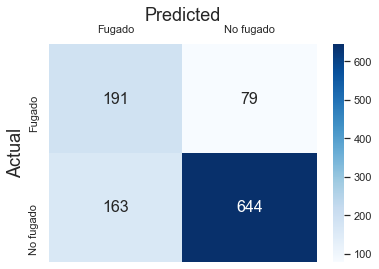

In [31]:
fig, ax = plt.subplots()
sns.heatmap(cmDF, annot=True, annot_kws={"size": 16}, fmt='', cmap=plt.cm.Blues)
plt.tick_params(labelbottom=False, labeltop=True, labelright=False)

ax.set_xlabel('Predicted', fontsize=18)
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Actual', fontsize=18)

In [32]:
print(classification_report(testY, predY, labels=['Yes', 'No']))

              precision    recall  f1-score   support

         Yes       0.54      0.71      0.61       270
          No       0.89      0.80      0.84       807

    accuracy                           0.78      1077
   macro avg       0.72      0.75      0.73      1077
weighted avg       0.80      0.78      0.78      1077



---
## Modelo 3

Probaremos todos los métodos de clasificación, excepto DeepLearning

In [33]:
model = H2OAutoML(max_runtime_secs=5*60, max_runtime_secs_per_model=30,
                  seed=42, nfolds=5,
                  exclude_algos=["DeepLearning"], verbosity="info")

In [34]:
model.train(x=columnsX, y=columnsY, training_frame=trainDF, validation_frame=valDF)

AutoML progress: |
13:57:58.184: Project: AutoML_20201124_135758184
13:57:58.185: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
13:57:58.185: Setting stopping tolerance adaptively based on the training frame: 0.014154880754301795
13:57:58.185: Build control seed: 42
13:57:58.185: training frame: Frame key: automl_training_py_3_sid_8351    cols: 21    rows: 4991  chunks: 64    size: 983782  checksum: -1669374468636989084
13:57:58.185: validation frame: Frame key: py_4_sid_8351    cols: 21    rows: 975  chunks: 64    size: 851811  checksum: 7253048788233046041
13:57:58.185: leaderboard frame: NULL
13:57:58.185: blending frame: NULL
13:57:58.185: response column: Churn
13:57:58.185: fold column: null
13:57:58.185: weights column: null
13:57:58.185: AutoML: XGBoost is not available

### Analizamos las métricas de los modelos entrenados

In [35]:
leaderboard = model.leaderboard
leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20201124_135758,0.848665,0.422017,0.662147,0.22452,0.368849,0.13605
GBM_grid__1_AutoML_20201124_135758_model_14,0.848578,0.414235,0.665097,0.226543,0.367117,0.134775
StackedEnsemble_AllModels_AutoML_20201124_135758,0.848242,0.42312,0.661848,0.23287,0.369242,0.13634
GBM_5_AutoML_20201124_135758,0.848016,0.415084,0.658824,0.236111,0.367934,0.135375
GLM_1_AutoML_20201124_135758,0.844398,0.419635,0.648005,0.235901,0.370243,0.13708
GBM_grid__1_AutoML_20201124_135758_model_4,0.843129,0.420635,0.653557,0.23316,0.370093,0.136969
GBM_grid__1_AutoML_20201124_135758_model_15,0.841913,0.422543,0.651256,0.232334,0.371399,0.137937
GBM_1_AutoML_20201124_135758,0.841401,0.423233,0.653183,0.236657,0.371257,0.137832
GBM_grid__1_AutoML_20201124_135758_model_6,0.841368,0.422417,0.655967,0.235504,0.371262,0.137835
GBM_2_AutoML_20201124_135758,0.840599,0.425989,0.650579,0.237453,0.372055,0.138425


### Calculamos las métricas del clasificador

In [36]:
#model.leader.model_performance(testDF)

In [37]:
predDF = model.leader.predict(testDF)

predDF.head()

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,No,Yes
Yes,0.273725,0.726275
No,0.93982,0.0601796
No,0.927075,0.0729249
No,0.932264,0.067736
No,0.916832,0.083168
Yes,0.634909,0.365091
No,0.923737,0.0762635
No,0.852444,0.147556
No,0.911335,0.0886654
Yes,0.715827,0.284173


In [38]:
testY = testDF.as_data_frame()['Churn'].values
predY = predDF.as_data_frame()['predict'].values

In [39]:
labels = ['Fugado', 'No fugado']
cmDF = pd.DataFrame(confusion_matrix(testY, predY, labels=['Yes', 'No']), index=labels, columns=labels)

cmDF

,Fugado,No fugado
Fugado,200,70
No fugado,185,622


Text(30.5, 0.5, 'Actual')

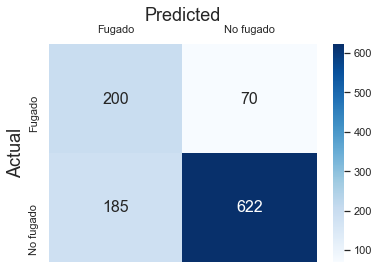

In [40]:
fig, ax = plt.subplots()
sns.heatmap(cmDF, annot=True, annot_kws={"size": 16}, fmt='', cmap=plt.cm.Blues)
plt.tick_params(labelbottom=False, labeltop=True, labelright=False)

ax.set_xlabel('Predicted', fontsize=18)
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Actual', fontsize=18)

In [41]:
print(classification_report(testY, predY, labels=['Yes', 'No']))

              precision    recall  f1-score   support

         Yes       0.52      0.74      0.61       270
          No       0.90      0.77      0.83       807

    accuracy                           0.76      1077
   macro avg       0.71      0.76      0.72      1077
weighted avg       0.80      0.76      0.77      1077



## Selecionamos un modelo en particular del leaderboard

In [42]:
leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20201124_135758,0.848665,0.422017,0.662147,0.22452,0.368849,0.13605
GBM_grid__1_AutoML_20201124_135758_model_14,0.848578,0.414235,0.665097,0.226543,0.367117,0.134775
StackedEnsemble_AllModels_AutoML_20201124_135758,0.848242,0.42312,0.661848,0.23287,0.369242,0.13634
GBM_5_AutoML_20201124_135758,0.848016,0.415084,0.658824,0.236111,0.367934,0.135375
GLM_1_AutoML_20201124_135758,0.844398,0.419635,0.648005,0.235901,0.370243,0.13708
GBM_grid__1_AutoML_20201124_135758_model_4,0.843129,0.420635,0.653557,0.23316,0.370093,0.136969
GBM_grid__1_AutoML_20201124_135758_model_15,0.841913,0.422543,0.651256,0.232334,0.371399,0.137937
GBM_1_AutoML_20201124_135758,0.841401,0.423233,0.653183,0.236657,0.371257,0.137832
GBM_grid__1_AutoML_20201124_135758_model_6,0.841368,0.422417,0.655967,0.235504,0.371262,0.137835
GBM_2_AutoML_20201124_135758,0.840599,0.425989,0.650579,0.237453,0.372055,0.138425


In [43]:
model_ids = list(leaderboard['model_id'].as_data_frame().iloc[:, 0])
model_ids

['StackedEnsemble_BestOfFamily_AutoML_20201124_135758',
 'GBM_grid__1_AutoML_20201124_135758_model_14',
 'StackedEnsemble_AllModels_AutoML_20201124_135758',
 'GBM_5_AutoML_20201124_135758',
 'GLM_1_AutoML_20201124_135758',
 'GBM_grid__1_AutoML_20201124_135758_model_4',
 'GBM_grid__1_AutoML_20201124_135758_model_15',
 'GBM_1_AutoML_20201124_135758',
 'GBM_grid__1_AutoML_20201124_135758_model_6',
 'GBM_2_AutoML_20201124_135758',
 'GBM_grid__1_AutoML_20201124_135758_model_10',
 'GBM_grid__1_AutoML_20201124_135758_model_2',
 'GBM_3_AutoML_20201124_135758',
 'GBM_grid__1_AutoML_20201124_135758_model_8',
 'GBM_4_AutoML_20201124_135758',
 'GBM_grid__1_AutoML_20201124_135758_model_9',
 'GBM_grid__1_AutoML_20201124_135758_model_12',
 'GBM_grid__1_AutoML_20201124_135758_model_5',
 'DRF_1_AutoML_20201124_135758',
 'XRT_1_AutoML_20201124_135758',
 'GBM_grid__1_AutoML_20201124_135758_model_13',
 'GBM_grid__1_AutoML_20201124_135758_model_7',
 'GBM_grid__1_AutoML_20201124_135758_model_11',
 'GBM_grid

In [44]:
gbm_model_ids = []
for model_id in model_ids:
    if "GBM" in model_id:
        gbm_model_ids.append(model_id)

print(gbm_model_ids)

['GBM_grid__1_AutoML_20201124_135758_model_14', 'GBM_5_AutoML_20201124_135758', 'GBM_grid__1_AutoML_20201124_135758_model_4', 'GBM_grid__1_AutoML_20201124_135758_model_15', 'GBM_1_AutoML_20201124_135758', 'GBM_grid__1_AutoML_20201124_135758_model_6', 'GBM_2_AutoML_20201124_135758', 'GBM_grid__1_AutoML_20201124_135758_model_10', 'GBM_grid__1_AutoML_20201124_135758_model_2', 'GBM_3_AutoML_20201124_135758', 'GBM_grid__1_AutoML_20201124_135758_model_8', 'GBM_4_AutoML_20201124_135758', 'GBM_grid__1_AutoML_20201124_135758_model_9', 'GBM_grid__1_AutoML_20201124_135758_model_12', 'GBM_grid__1_AutoML_20201124_135758_model_5', 'GBM_grid__1_AutoML_20201124_135758_model_13', 'GBM_grid__1_AutoML_20201124_135758_model_7', 'GBM_grid__1_AutoML_20201124_135758_model_11', 'GBM_grid__1_AutoML_20201124_135758_model_3', 'GBM_grid__1_AutoML_20201124_135758_model_1']


In [45]:
model_chosen_id = gbm_model_ids[0]
print(model_chosen_id)

GBM_grid__1_AutoML_20201124_135758_model_14


In [46]:
gbm_model = h2o.get_model(model_chosen_id)

In [47]:
gbm_model.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_grid__1_AutoML_20201124_135758_model_14',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_grid__1_AutoML_20201124_135758_model_14'},
  'input': None},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_py_3_sid_8351',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_py_3_sid_8351'},
  'input': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_py_3_sid_8351',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_py_3_sid_8351'}},
 'validation_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'py_4_sid_8351',
  

In [48]:
print(gbm_model)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20201124_135758_model_14


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,47.00,47.00,17082.00,6.00,10.00,7.77,21.00,27.00,24.23




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.12342213350699638
RMSE: 0.35131486377179716
LogLoss: 0.38206243708161247
Mean Per-Class Error: 0.20287244958445239
AUC: 0.8767399649247599
AUCPR: 0.7199109811219329
Gini: 0.7534799298495198

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34439293358205775: 


,,No,Yes,Error,Rate
0,No,2986.00,665.00,0.1821,(665.0/3651.0)
1,Yes,322.00,1018.00,0.2403,(322.0/1340.0)
2,Total,3308.00,1683.00,0.1978,(987.0/4991.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.34,0.67,205.00
1,max f2,0.17,0.78,287.00
2,max f0point5,0.49,0.67,143.00
3,max accuracy,0.46,0.82,157.00
4,max precision,0.89,1.00,0.00
5,max recall,0.02,1.00,388.00
6,max specificity,0.89,1.00,0.00
7,max absolute_mcc,0.41,0.55,177.00
8,max min_per_class_accuracy,0.31,0.79,220.00
9,max mean_per_class_accuracy,0.26,0.80,243.00



Gains/Lift Table: Avg response rate: 26.85 %, avg score: 26.84 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01,0.85,3.50,3.50,0.94,0.86,0.94,0.86,0.04,0.04,250.11,250.11,0.03
1,2,0.02,0.83,3.58,3.54,0.96,0.84,0.95,0.85,0.04,0.07,257.56,253.84,0.07
2,3,0.03,0.81,3.28,3.45,0.88,0.82,0.93,0.84,0.03,0.10,227.77,245.15,0.10
3,4,0.04,0.79,3.13,3.37,0.84,0.80,0.91,0.83,0.03,0.14,212.87,237.08,0.13
4,5,0.05,0.76,3.20,3.34,0.86,0.78,0.90,0.82,0.03,0.17,220.32,233.73,0.16
5,6,0.10,0.65,2.73,3.03,0.73,0.71,0.81,0.76,0.14,0.30,172.64,203.18,0.28
6,7,0.15,0.59,2.47,2.84,0.66,0.62,0.76,0.72,0.12,0.43,146.81,184.44,0.38
7,8,0.20,0.52,2.15,2.67,0.58,0.55,0.72,0.67,0.11,0.53,114.54,166.95,0.46
8,9,0.30,0.38,1.75,2.36,0.47,0.45,0.63,0.60,0.18,0.71,75.41,136.46,0.56
9,10,0.40,0.27,1.24,2.08,0.33,0.33,0.56,0.53,0.12,0.83,23.91,108.33,0.59




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13441618246932874
RMSE: 0.3666281255841247
LogLoss: 0.41934645760510475
Mean Per-Class Error: 0.23405178921938696
AUC: 0.841658398222644
AUCPR: 0.6715796426715811
Gini: 0.683316796445288

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4248066764708673: 


,,No,Yes,Error,Rate
0,No,624.00,92.00,0.1285,(92.0/716.0)
1,Yes,92.00,167.00,0.3552,(92.0/259.0)
2,Total,716.00,259.00,0.1887,(184.0/975.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.42,0.64,155.00
1,max f2,0.11,0.74,309.00
2,max f0point5,0.48,0.65,135.00
3,max accuracy,0.48,0.81,135.00
4,max precision,0.90,1.00,0.00
5,max recall,0.01,1.00,396.00
6,max specificity,0.90,1.00,0.00
7,max absolute_mcc,0.42,0.52,155.00
8,max min_per_class_accuracy,0.30,0.76,208.00
9,max mean_per_class_accuracy,0.30,0.77,204.00



Gains/Lift Table: Avg response rate: 26.56 %, avg score: 26.58 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01,0.85,3.39,3.39,0.90,0.87,0.90,0.87,0.03,0.03,238.80,238.80,0.03
1,2,0.02,0.83,3.01,3.20,0.80,0.84,0.85,0.86,0.03,0.07,201.16,219.98,0.06
2,3,0.03,0.81,3.39,3.26,0.90,0.82,0.87,0.84,0.03,0.10,238.80,226.25,0.09
3,4,0.04,0.77,3.35,3.28,0.89,0.79,0.87,0.83,0.03,0.13,234.62,228.19,0.12
4,5,0.05,0.76,3.39,3.30,0.90,0.77,0.88,0.82,0.03,0.17,238.80,230.35,0.16
5,6,0.10,0.67,2.61,2.96,0.69,0.71,0.79,0.76,0.13,0.30,161.21,195.78,0.27
6,7,0.15,0.59,2.46,2.79,0.65,0.63,0.74,0.72,0.12,0.42,145.84,179.13,0.37
7,8,0.20,0.52,1.80,2.55,0.48,0.55,0.68,0.68,0.09,0.51,80.38,154.83,0.42
8,9,0.30,0.38,1.65,2.25,0.44,0.44,0.60,0.60,0.17,0.68,65.18,124.84,0.51
9,10,0.40,0.27,0.97,1.93,0.26,0.32,0.51,0.53,0.10,0.77,-2.98,93.05,0.51




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.13477460031282437
RMSE: 0.3671166031560332
LogLoss: 0.4142350817961849
Mean Per-Class Error: 0.22533194749342855
AUC: 0.8485779810888041
AUCPR: 0.6650969984652877
Gini: 0.6971559621776082

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30289826076638293: 


,,No,Yes,Error,Rate
0,No,2806.00,845.00,0.2314,(845.0/3651.0)
1,Yes,297.00,1043.00,0.2216,(297.0/1340.0)
2,Total,3103.00,1888.00,0.2288,(1142.0/4991.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.30,0.65,220.00
1,max f2,0.20,0.76,270.00
2,max f0point5,0.50,0.63,137.00
3,max accuracy,0.50,0.80,137.00
4,max precision,0.88,1.00,0.00
5,max recall,0.01,1.00,392.00
6,max specificity,0.88,1.00,0.00
7,max absolute_mcc,0.30,0.50,220.00
8,max min_per_class_accuracy,0.31,0.77,218.00
9,max mean_per_class_accuracy,0.28,0.77,229.00



Gains/Lift Table: Avg response rate: 26.85 %, avg score: 26.92 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01,0.84,3.20,3.20,0.86,0.85,0.86,0.85,0.03,0.03,220.32,220.32,0.03
1,2,0.02,0.82,3.43,3.31,0.92,0.83,0.89,0.84,0.03,0.07,242.67,231.49,0.06
2,3,0.03,0.80,3.28,3.30,0.88,0.81,0.89,0.83,0.03,0.10,227.77,230.25,0.09
3,4,0.04,0.78,2.98,3.22,0.80,0.79,0.86,0.82,0.03,0.13,197.97,222.18,0.12
4,5,0.05,0.76,2.61,3.10,0.70,0.77,0.83,0.81,0.03,0.16,160.72,209.89,0.14
5,6,0.10,0.67,2.68,2.89,0.72,0.71,0.78,0.76,0.13,0.29,168.17,189.03,0.26
6,7,0.15,0.59,2.09,2.63,0.56,0.63,0.70,0.72,0.10,0.39,109.42,162.56,0.33
7,8,0.20,0.52,2.07,2.49,0.56,0.55,0.67,0.68,0.10,0.50,107.09,148.68,0.41
8,9,0.30,0.38,1.78,2.25,0.48,0.45,0.60,0.60,0.18,0.68,77.65,125.02,0.51
9,10,0.40,0.28,1.26,2.00,0.34,0.33,0.54,0.53,0.13,0.80,26.14,100.31,0.55




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7874145,0.011230273,0.8018018,0.78356713,0.7825651,0.7735471,0.7955912
1,auc,0.84891045,0.011769102,0.86699903,0.854038,0.84344023,0.84260416,0.8374707
2,aucpr,0.6683891,0.03740776,0.71117234,0.7025444,0.6619666,0.62709504,0.6391671
3,err,0.21258554,0.011230273,0.1981982,0.21643287,0.21743487,0.2264529,0.20440882
4,err_count,212.2,11.1445055,198.0,216.0,217.0,226.0,204.0
5,f0point5,0.6085659,0.021365907,0.6329114,0.60650027,0.6127733,0.57457924,0.6160653
6,f1,0.6555338,0.017704498,0.6796116,0.659306,0.66251945,0.6366559,0.63957596
7,f2,0.71114314,0.026794856,0.7337526,0.7221838,0.7210562,0.71377075,0.6649522
8,lift_top_group,3.3533714,0.26072294,3.6863468,3.3143911,3.2309353,3.522353,3.0128303
9,logloss,0.41423917,0.013935156,0.39377502,0.40914634,0.4284922,0.41419044,0.42559192



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-11-24 13:58:33,18.499 sec,0.00,0.44,0.58,0.50,0.27,1.00,0.73,0.44,0.58,0.50,0.27,1.00,0.73
1,,2020-11-24 13:58:33,18.515 sec,5.00,0.40,0.49,0.85,0.66,3.23,0.22,0.40,0.49,0.83,0.67,3.08,0.23
2,,2020-11-24 13:58:33,18.536 sec,10.00,0.38,0.45,0.86,0.67,3.20,0.22,0.38,0.45,0.84,0.66,3.39,0.21
3,,2020-11-24 13:58:33,18.557 sec,15.00,0.37,0.43,0.86,0.69,3.44,0.22,0.37,0.44,0.84,0.67,3.01,0.21
4,,2020-11-24 13:58:33,18.580 sec,20.00,0.36,0.41,0.86,0.69,3.51,0.22,0.37,0.42,0.84,0.68,3.01,0.22
5,,2020-11-24 13:58:33,18.603 sec,25.00,0.36,0.40,0.87,0.70,3.58,0.22,0.37,0.42,0.84,0.67,3.39,0.22
6,,2020-11-24 13:58:33,18.625 sec,30.00,0.36,0.40,0.87,0.70,3.58,0.20,0.37,0.42,0.84,0.67,3.39,0.20
7,,2020-11-24 13:58:33,18.647 sec,35.00,0.36,0.39,0.87,0.71,3.58,0.19,0.37,0.42,0.84,0.67,3.01,0.19
8,,2020-11-24 13:58:34,18.671 sec,40.00,0.35,0.39,0.87,0.71,3.65,0.20,0.37,0.42,0.84,0.67,3.39,0.19
9,,2020-11-24 13:58:34,18.695 sec,45.00,0.35,0.38,0.88,0.72,3.51,0.20,0.37,0.42,0.84,0.67,3.01,0.20



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,361.10,1.00,0.22
1,tenure,296.90,0.82,0.18
2,OnlineSecurity,207.18,0.57,0.13
3,InternetService,167.12,0.46,0.10
4,PaymentMethod,166.75,0.46,0.10
5,TotalCharges,122.57,0.34,0.07
6,MonthlyCharges,76.20,0.21,0.05
7,TechSupport,53.02,0.15,0.03
8,PaperlessBilling,38.25,0.11,0.02
9,DeviceProtection,30.35,0.08,0.02


### Exportamos el modelo

In [49]:
modelFile = h2o.save_model(model=gbm_model, path=modelsDir, force=True)
print(modelFile)

C:\Users\rmunoz\Github\personal\taller_copec\notebooks\models\GBM_grid__1_AutoML_20201124_135758_model_14
